# Miniproject 3: Poem Generation

### Download Data

In [1]:
import requests
import re
import numpy as np
import random
import matplotlib.pyplot as plt

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


## Sonnet Class

In [2]:
class Sonnet:
    def __init__(self,filename,sequenceType,sylDict):

        # initialize vars
        self.filename = filename
        self.sequenceType = sequenceType
        self.sonnetLengthList = [12,13,14,15]
        self.sylDict = sylDict
        self.punctList = [",",".",":",";","?","!",")"]

        # initialize lists
        self.read()
        self.buildSequenceStr()
        self.buildSyllableList()
        self.parse_observations()
        self.obs_map_reverser()
        self.buildRhymeDict()

    def read(self):

        # open file
        f = open(self.filename,"r")

        # count and store sonnets
        sonnetList = []
        thisSonnet = []

        # create dictionary for punctuation
        pDict = {}
        for p in self.punctList:
            pDict.update({p:0})
        noPunctCount = 0

        # iterate through sonnets
        sCount = 0
        for x in f:

            # determine whether number, line, or blank space
            thisStr = x[0:-1]
            thisWC = len(thisStr.split())

            # determine whether new sonnet
            newSonnet = False                
            if thisWC == 0:
                if len(thisSonnet) in self.sonnetLengthList:
                    newSonnet = True
                else:
                    thisSonnet = []

            if newSonnet: # number
                thisLen = len(thisSonnet)
                if thisLen in self.sonnetLengthList:
                    sonnetList.append(thisSonnet.copy())
                else:
                    raise Exception("Length not supported")
                sCount += 1
                thisSonnet = []            
            elif thisWC > 1: # line
                thisStr = x[0:-1]
                thisList = thisStr.split()
                thisWordList = []
                for jdx in range(len(thisList)):
                    word = thisList[jdx].lower()

                    # modify word
                    cleanBool = False
                    modBool = False
                    while cleanBool == False:
                        if word[-1] in self.punctList:
                            thisP = word[-1]
                            thisCount = pDict.get(thisP)
                            pDict.update({thisP:thisCount+1})
                            word = word[:-1]
                            modBool = True
                        elif word[0] == "(":
                            word = word[1:]
                            modBool = True
                        elif word[-1] == "'":
                            if word[-2] in self.punctList:
                                word = word[:-2]
                                modBool = True
                            else:
                                cleanBool = True
                        else:
                            cleanBool = True
                    thisWordList.append(word)
                    if modBool:
                        noPunctCount += 1
                thisSonnet.append(thisWordList.copy())

        # handle final sonnet
        if len(thisSonnet) in self.sonnetLengthList:
            sonnetList.append(thisSonnet.copy())
        else:
            raise Exception("Length of sonnet is wrong")
        
        # handle blank spaces
        pDict.update({" ":noPunctCount})

        # store values
        self.sonnetList = sonnetList
        self.pDict = pDict        
        pass
    
    def buildRhymeDict(self):
        wordRhymeDict = {}
        for thisStanza in self.sequenceListStrMod:

            # get rhyming pattern
            if len(thisStanza) == 4:
                rhymeList = 'abab'
            elif len(thisStanza) == 2:
                rhymeList = 'aa'
            elif len(thisStanza) == 5:
                rhymeList = 'ababa'
            else:
                raise Exception("Length of stanza not specified properly")
            
            rhymeUniqueList = ''.join(set(rhymeList))
            for thisChar in rhymeUniqueList:
                thisList = []
                for idx in range(len(rhymeList)):
                    if thisChar == rhymeList[idx]:
                        thisList.append(thisStanza[idx][-1])
                for idx in range(len(thisList)):

                    # get key and entry for dict
                    thisKey = thisList[idx]
                    thisEntry = thisList[0:idx]
                    for jdx in range(idx+1,len(thisList)):
                        thisEntry.append(thisList[jdx])
                    
                    # check if key already exists
                    newEntryBool = False
                    if thisKey in wordRhymeDict.keys():
                        oldEntry = wordRhymeDict.get(thisKey)
                        newEntry = oldEntry.copy()
                        for jdx in range(len(thisEntry)):
                            if thisEntry[jdx] not in oldEntry:
                                newEntry.append(thisEntry[jdx])
                                newEntryBool = True
                        if newEntryBool:
                            thisDict = {thisKey:newEntry}
                            wordRhymeDict.update(thisDict)
                    else:
                        thisDict = {thisKey:thisEntry}
                        wordRhymeDict.update(thisDict)
        self.wordRhymeDict = wordRhymeDict
        pass
    
    def buildSequenceStr(self):
        if self.sequenceType == "Stanza":
            self.sequenceStanzaStr()
        else:
            raise Exception("Sequence type not specified")

    def sequenceStanzaStr(self):
        """
        Group sequences by stanza
        13 lines: 3 + 4 + 4 + 2
        14 lines: 4 + 4 + 4 + 2
        15 lines: 5 + 4 + 4 + 2
        12 lines: 2 + 2 + 2 + 2 + 2 + 2
        """
        sequenceList = []

        # iterate through sonnets
        for sdx in range(len(self.sonnetList)):
            
            # get structure of sonnets
            thisLen = len(self.sonnetList[sdx])           
            if thisLen == 12:
                iList = [0,2,4,6,8,10,12]
            elif thisLen == 13:
                iList = [0,3,7,11,13]
            elif thisLen == 14:
                iList = [0,4,8,12,14]     
            elif thisLen == 15:
                iList = [0,5,9,13,15]
            else:
                raise Exception("Sonnet length not handled properly: ", thisLen)
            
            # iterate through stanzas
            for idx in range(len(iList)-1):
                thisStanza = []
                iStart = iList[idx]
                iStop = iList[idx+1]

                # iterate through lines
                for jdx in range(iStart,iStop):
                    thisStanza.append(self.sonnetList[sdx][jdx].copy())
                
                # store stanza in sequence list
                sequenceList.append(thisStanza)

        self.sequenceListStr = sequenceList
        pass
    
    def buildSyllableList(self):
        
        # get empty lists
        sequenceSylList = []
        sequenceListStrMod = []

        # iterate through stanzas
        for sdx in range(len(self.sequenceListStr)):
            thisStanza = self.sequenceListStr[sdx]
            sylStanza = []
            wordStanza = []

            # keep stanza?
            discardStanzaBool = False

            # iterate through lines in stanza
            for ldx in range(len(thisStanza)):
                lineSylCountListMin = []
                lineSylCountListMax = []
                wordList = []

                # iterate through words in stanza
                for wdx in range(len(thisStanza[ldx])):
                    # get word
                    word = thisStanza[ldx][wdx]
                    
                    # last word in line?
                    endBool = wdx == (len(thisStanza[ldx]) - 1)
                    # get syllable count for word
                    try:
                        thisDict = self.sylDict[word]
                    except:
                        modBool = True
                        dictReadFailBool = True
                        while modBool and dictReadFailBool:
                            if word[0] == "'":
                                modBool = True
                                word = word[1:]
                            elif word[-1] == "'":
                                modBool = True
                                word = word[:-1]
                            else:
                                modBool = False
                            if modBool:
                                try:
                                    thisDict = self.sylDict[word]
                                    dictReadFailBool = False
                                except:
                                    dictReadFailBool = True
                                if not modBool:
                                    raise Exception("Failed to read word from dictionary")
                            else:
                                raise Exception("Failed to read word from dictionary")
                            
                    if len(thisDict) == 1:
                        sylCountList = [int(thisDict[0])]
                    else:
                        sylCountList = []

                        # get possible list of syllable counts
                        for ddx in range(len(thisDict)):
                            if thisDict[ddx][0] == 'E':
                                if endBool:
                                    sylCount = int(thisDict[ddx][1])
                                    sylCountList = [sylCount]
                                    break
                            else:
                                sylCountList.append(int(thisDict[ddx][0]))

                    # save word
                    wordList.append(word)

                    # get syllable count (for line)
                    if len(sylCountList) == 1:
                        sylCount = sylCountList[0]
                        lineSylCountListMin.append(sylCount)
                        lineSylCountListMax.append(sylCount)                   
                    else:
                        lineSylCountListMax.append(max(sylCountList))
                        lineSylCountListMin.append(min(sylCountList))
                    
                # check syllable count
                if sum(lineSylCountListMax) == 10:
                    lineSylCountList = lineSylCountListMax.copy()
                elif sum(lineSylCountListMin) == 10:
                    lineSylCountList = lineSylCountListMin.copy()
                else:
                    if sum(lineSylCountListMin) > 10 or sum(lineSylCountListMax) < 10:
                        lineSylCountList = []
                        discardStanzaBool = True
                    else:
                        # count being and whether
                        beingIndexList = []
                        whetherIndexList = []
                        crownedIndexList = []
                        flowerIndexList = []
                        for wdx in range(len(thisStanza[ldx])):
                            word = re.sub(r'[^\w]', '', thisStanza[ldx][wdx]).lower()
                            if word == 'being':
                                beingIndexList.append(wdx)
                            elif word == 'whether':
                                whetherIndexList.append(wdx)
                            elif word == 'crowned':
                                crownedIndexList.append(wdx)
                            elif word == 'flowers':
                                flowerIndexList.append(wdx)

                        if len(beingIndexList) in [1,2] and sum(lineSylCountListMax) == 11: # handle being
                            lineSylCountList = lineSylCountListMax.copy()
                            lineSylCountList[beingIndexList[0]] = 1
                        elif len(whetherIndexList) in [1,2] and sum(lineSylCountListMax) == 11: # handle whether
                            lineSylCountList = lineSylCountListMax.copy()
                            lineSylCountList[whetherIndexList[0]] = 1
                        elif len(crownedIndexList) == 1 and len(whetherIndexList) == 1 and len(beingIndexList) == 1 and sum(lineSylCountListMax) == 12:
                            lineSylCountList = lineSylCountListMax.copy()
                            lineSylCountList[crownedIndexList[0]] = 1
                            lineSylCountList[beingIndexList[0]] = 1
                        elif len(flowerIndexList) in [1,2] and sum(lineSylCountListMax) == 11: # handle flower
                            lineSylCountList = lineSylCountListMax.copy()
                            lineSylCountList[flowerIndexList[0]] = 1
                        else:
                            raise Exception("Problem with syllable count")
                
                # check syllable count
                if sum(lineSylCountList) != 10:
                    discardStanzaBool = True

                # store values (by stanza)
                sylStanza.append(lineSylCountList)
                wordStanza.append(wordList)
        
            # add values back to sequence
            if not discardStanzaBool:
                sequenceSylList.append(sylStanza)
                sequenceListStrMod.append(wordStanza)
            
        # add values to class
        self.sequenceSylList = sequenceSylList
        self.sequenceListStrMod = sequenceListStrMod
        pass
    
    def parse_observations(self):

        obs_counter = 0
        obs = []
        obs_map = {}

        # iterate through stanzas
        for sdx in range(len(self.sequenceListStrMod)):
            obs_elem = []
            thisStanza = self.sequenceListStrMod[sdx]
            thisStanzaSyl = self.sequenceSylList[sdx]

            # iterate through lines in stanza
            for ldx in range(len(thisStanza)):
                    
                # iterate through words in stanza
                for wdx in range(len(thisStanza[ldx])):
                    
                    # get word and its syllable count
                    word = thisStanza[ldx][wdx]
                    if word == "i":
                        word = "I"
                    thisCount = thisStanzaSyl[ldx][wdx]
                    thisObs = word# + str(thisCount)
                    
                    if thisObs not in obs_map:
                        # Add unique words to the observations map.
                        obs_map[thisObs] = obs_counter
                        obs_counter += 1

                    # Add the encoded word
                    obs_elem.append(obs_map[thisObs])
                
                # Add the encoded sequence
                obs.append(obs_elem)

        # store values
        self.obs = obs
        self.obs_map = obs_map
        self.obs_counter = obs_counter
        pass
    
    def obs_map_reverser(self):
        obs_map_r = {}

        for key in self.obs_map:
            obs_map_r[self.obs_map[key]] = key

        self.obs_map_r = obs_map_r
        pass

class SonnetStress(Sonnet):
    def __init__(self,filename,sequenceType,sylDict):

        # initialize vars
        self.filename = filename
        self.sequenceType = sequenceType
        self.sonnetLengthList = [12,13,14,15]
        self.sylDict = sylDict
        self.punctList = [",",".",":",";","?","!",")"]

        # initialize lists
        self.read()
        self.buildSequenceStr()
        self.buildSyllableList()
        self.buildStressList()
        self.parse_observations()
        self.obs_map_reverser()
        self.buildRhymeDict()

    def buildStressList(self):
        sequenceStressList = []
        for sdx in range(len(self.sequenceListStrMod)):
            thisStanza = self.sequenceListStrMod[sdx]
            stressStanza = []
            for ldx in range(len(thisStanza)):
                sylCumSum = np.cumsum(self.sequenceSylList[sdx][ldx])
                thisStress = []
                for wdx in range(len(thisStanza[ldx])):
                    if wdx == 0:
                        thisStress.append(False)
                    elif sylCumSum[wdx-1] % 2 == 0:
                        thisStress.append(False)
                    else:
                        thisStress.append(True)
                stressStanza.append(thisStress.copy())
            sequenceStressList.append(stressStanza)
        self.sequenceStressList = sequenceStressList
        pass

    def parse_observations(self):

        obs_counter = 0
        obs = []
        obs_map = {}

        # iterate through stanzas
        for sdx in range(len(self.sequenceListStrMod)):
            obs_elem = []
            thisStanza = self.sequenceListStrMod[sdx]
            thisStanzaStress = self.sequenceStressList[sdx]

            # iterate through lines in stanza
            for ldx in range(len(thisStanza)):
                    
                # iterate through words in stanza
                for wdx in range(len(thisStanza[ldx])):
                    
                    # get word and its syllable count
                    word = thisStanza[ldx][wdx]
                    if word == "i":
                        word = "I"
                    thisStress = thisStanzaStress[ldx][wdx]
                    thisObs = word + str(int(thisStress))
                    
                    if thisObs not in obs_map:
                        # Add unique words to the observations map.
                        obs_map[thisObs] = obs_counter
                        obs_counter += 1

                    # Add the encoded word
                    obs_elem.append(obs_map[thisObs])
                
                # Add the encoded sequence
                obs.append(obs_elem)

        # store values
        self.obs = obs
        self.obs_map = obs_map
        self.obs_counter = obs_counter
        pass


## HMM Class

In [3]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.

            D:          Number of observations.

            A:          The transition matrix.

            O:          The observation matrix.

            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''
        #A = [[0.7,0.3],[0.4,0.6]]
        #O = [[0.5,0.4,0.1],[0.1,0.3,0.6]]
        #self.A_start = [0.6,0.4]
        
        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]
        


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''
        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M+1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M+1)]

        for ydx in range(self.L):
            probs[0][ydx] = self.A_start[ydx]
            probs[1][ydx] = self.A_start[ydx] * self.O[ydx][x[0]]
            seqs[1][ydx] = str(ydx)
        
        for xdx in range(1,M): # iterate through x
            for ydx in range(self.L): # iterate through next Y
                p_xGy = self.O[ydx][x[xdx]]
                thisMax = 0
                idxMax = None
                for pdx in range(self.L): # iterate through previous Y
                    p_yGx = probs[xdx][pdx] # previous table values
                    p_yGy = self.A[pdx][ydx] # p of pdx to jdx
                    thisP = p_xGy * p_yGy * p_yGx
                    if thisP  > thisMax:
                        thisMax = thisP
                        idxMax = pdx
                        
                probs[xdx+1][ydx] = thisMax
                if idxMax is None:
                    seqs[xdx+1][ydx] = ""
                else:
                    thisStr = seqs[xdx][idxMax] + str(ydx)
                    seqs[xdx+1][ydx] = thisStr
        
        # find MAP sequence
        thisMax = 0
        idxMax = None
        for ydx in range(self.L):
            thisProbs = probs[M][ydx]
            if thisProbs > thisMax:
                idxMax = ydx
                thisMax = thisProbs
        max_seq = seqs[M][idxMax]
        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
            alphas[1][i] = self.A_start[i] * self.O[i][x[0]]

        for d in range(2, M + 1):

            for curr_state in range(self.L):
                prob = 0
                for prev_state in range(self.L):
                    prob += (self.O[curr_state][x[d-1]] * (alphas[d-1][prev_state] * self.A[prev_state][curr_state]))

                alphas[d][curr_state] = prob

            if normalize:
                denom = np.sum(alphas[d])
                alphas[d] = [alpha/denom for alpha in alphas[d]]


        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
            betas[M][i] = 1

        for d in range(M - 1, -1, -1):

            for curr_state in range(self.L):
                prob = 0
                for next_state in range(self.L):
                    if d == 0:
                        prob += (betas[d+1][next_state] * self.A_start[next_state] * self.O[next_state][x[d]])
                    else:
                        prob += (betas[d+1][next_state] * self.A[curr_state][next_state] * self.O[next_state][x[d]])

                betas[d][curr_state] = prob

            if normalize:
                denom = np.sum(betas[d])
                betas[d] = [beta/denom for beta in betas[d]]

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for adx in range(self.L):
            for bdx in range(self.L):
                cN = 0
                cD = 0
                for ldx in range(len(X)):
                    for jdx in range(1,len(X[ldx])):

                        # handle data in current time period
                        if Y[ldx][jdx-1] == bdx:
                            cD += 1
                            if Y[ldx][jdx] == adx:
                                cN += 1
                                                    
                # store values
                self.A[bdx][adx] = cN / cD

        # verify A
        for adx in range(self.L):
            thisErr = abs(sum(self.A[adx])-1)
            if thisErr > 1e-12:
                print("Error in Evolution Matrix: ",thisErr)

        # Calculate each element of O using the M-step formulas.
        for wdx in range(self.D):
            for zdx in range(self.L):
                cN = 0
                cD = 0
                for ldx in range(len(X)):
                    for jdx in range(len(X[ldx])):
                        if Y[ldx][jdx] == zdx:
                            cD += 1
                            if X[ldx][jdx] == wdx:
                                cN += 1
                self.O[zdx][wdx] = cN / cD
        
        # verify O
        for zdx in range(self.L):
            thisErr = abs(sum(self.O[zdx])-1)
            if thisErr > 1e-12:
                print("Error in Observation Matrix")
        
        pass


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
        '''
        oTol = 1e-5
        aTol = 1e-5
        for i in range(N_iters):
            A_numer = np.zeros((self.L, self.L))
            A_denom = np.zeros((self.L, self.L))
            O_numer = np.zeros((self.L, self.D))
            O_denom = np.zeros((self.L, self.D))

            for x in X:
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)
                M = len(x)

                for d in range(1, M + 1):
                    prob_OAd = np.array([alphas[d][curr_state] * betas[d][curr_state] for curr_state in range(self.L)])
                    prob_OAd /= np.sum(prob_OAd)

                    for curr_state in range(self.L):
                        O_numer[curr_state][x[d-1]] += prob_OAd[curr_state]
                        O_denom[curr_state] += prob_OAd[curr_state]
                        if d != M:
                            A_denom[curr_state] += prob_OAd[curr_state]

                for d in range(1, M):
                    prob_An = np.array([[alphas[d][curr_state] \
                                    * self.O[next_state][x[d]] \
                                    * self.A[curr_state][next_state] \
                                    * betas[d+1][next_state] \
                                    for next_state in range(self.L)] \
                                    for curr_state in range(self.L)])
                    prob_An /= np.sum(prob_An)

                    for curr_state in range(self.L):
                        for next_state in range(self.L):
                            A_numer[curr_state][next_state] += prob_An[curr_state][next_state]
            thisA = A_numer / A_denom
            thisO = O_numer / O_denom
            diffA = np.linalg.norm(thisA-self.A)
            diffO = np.linalg.norm(thisO-self.O)
            if diffO < oTol and diffA < aTol:
                print("HMM Training terminates after {:d} iterations".format(i+1))
                break
            else:
                print("HMM Training iteration {:d}".format(i+1))
                print("A error {:3e}, O error {:3e}".format(diffA,diffO))
                self.A = A_numer / A_denom
                self.O = O_numer / O_denom
                    
        pass


    def generate_emission(self, M, rng=None, e0 = None, s0 = None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        # (Re-)Initialize random number generator
        if rng is None:
            rng = np.random.default_rng()

        if e0 is None and s0 is None:
            emission = []
            states = []
            r0 = range(M)
        else:
            emission = [e0]
            states = [s0]
            M += 1
            r0 = range(1,M)

        # get array of random numbs
        randArr = rng.random((M,2))
        
        for mdx in r0:
            
            # get probability of y given y
            if mdx == 0:
                pyy = np.ones(self.L) / self.L
            else:
                pyy = self.A[states[mdx-1]]
            pyy_sum1 = np.cumsum(pyy)
            pyy_sum = np.zeros(self.L+1)
            pyy_sum[1:] = pyy_sum1

            # get states
            for ldx in range(self.L):
                if randArr[mdx,0] > pyy_sum[ldx] and randArr[mdx,0] <= pyy_sum[ldx+1]:
                    states.append(ldx)
            
            # get probabiliy of x given y
            pxy = self.O[states[mdx]]
            pxy_sum1 = np.cumsum(pxy)
            pxy_sum = np.zeros(self.D+1)
            pxy_sum[1:] = pxy_sum1

            # get observation
            for ddx in range(self.D):
                if randArr[mdx,1] > pxy_sum[ddx] and randArr[mdx,1] <= pxy_sum[ddx+1]:
                    emission.append(ddx)

        return emission, states
    
    def generate_emission_r(self, M, lastObs, lastState = None, rng=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        # (Re-)Initialize random number generator
        if rng is None:
            rng = np.random.default_rng()

        # intialize list
        emission = [np.nan for _ in range(M+1)]
        states = [np.nan for _ in range(M+1)]

        # assume a uniform prior
        py = np.ones(self.L) / self.L

        # generate emission
        emission[-1] = lastObs
        if lastState is None:
            # get p(y|x)
            pyGx = []
            for idx in range(self.L):
                pyGx.append(self.O[idx][lastObs] * py[idx])
            pyGx_sum1 = np.cumsum(pyGx)
            pyGx_sum = np.zeros(self.L+1)
            pyGx_sum[1:] = pyGx_sum1 / np.sum(pyGx)
            
            # get states
            thisR = rng.random(1)
            for ldx in range(self.L):
                if thisR > pyGx_sum[ldx] and thisR <= pyGx_sum[ldx+1]:
                    states[-1] = ldx
        else:
            states[-1] = lastState
        
        for mdx in range(M,0,-1):
            
            # get probability of y given next y
            pyGy = []
            for idx in range(self.L):
                pyGy.append(self.A[idx][states[mdx]])
            pyGy_sum1 = np.cumsum(pyGy)
            pyGy_sum = np.zeros(self.L+1)
            pyGy_sum[1:] = pyGy_sum1 / np.sum(pyGy)

            # get states
            thisR = rng.random(1)
            for ldx in range(self.L):
                if thisR > pyGy_sum[ldx] and thisR <= pyGy_sum[ldx+1]:
                    states[mdx-1] = ldx
            
            # get probabiliy of x given y
            pxGy = self.O[states[mdx-1]]
            pxGy_sum1 = np.cumsum(pxGy)
            pxGy_sum = np.zeros(self.D+1)
            pxGy_sum[1:] = pxGy_sum1

            # get observation
            thisR = rng.random(1)
            for ddx in range(self.D):
                if thisR > pxGy_sum[ddx] and thisR <= pxGy_sum[ddx+1]:
                    emission[mdx-1] = ddx

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob

In [4]:
def unsupervised_HMM(X, n_states, N_iters, seed=None):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.

        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''
    # Initialize random number generator
    rng = np.random.default_rng(seed=seed)

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

## Code to read syllabus dictionary

In [5]:
def syllable_read(file):
    syllable = open(file, "r")
    syl = {}

    for x in syllable:
        line = x.split(" ")
        word = (line[0]).replace("\n", "")
        count = []
        for j in range(1, len(line)):
            thisCount = line[j].replace("\n","")
            count.append(thisCount)
        
        syl[word] = count

    syllable.close()
    
    return syl

## Class to write poems

In [6]:
class PoemWriter:
    def __init__(self,snClass,hmmClass):
        self.hmmClass = hmmClass
        self.snClass = snClass
        self.poemStructure = []

    def write_poem(self,seed=None):

        # create random number generator
        rng = np.random.default_rng(seed=seed)

        # include period?
        perBool1 = type(self).__name__ == 'SonnetWriter'
        perBool2 = type(self).__name__ == 'SonnetStressWriter'
        perBool = perBool1 or perBool2

        # Sample and convert sentence.
        poemList = []
        failBool = False
        for ldx in range(len(self.poemStructure)):
            
            # get number of syllables
            cTarget = self.poemStructure[ldx]

            # get line
            thisLineList, sylList = self.write_line(rng,cTarget)

            # ensure that line has the right number of syllables
            lineSylCountListMax, lineSylCountListMin = self.countSyllables(thisLineList)
            cMax = sum(lineSylCountListMax)
            cMin = sum(lineSylCountListMin)
            if cMax == cTarget or cMin == cTarget:
                thisLine = " ".join(thisLineList)
                thisLine = thisLine[0].capitalize() + thisLine[1:]
                if ldx == len(self.poemStructure)-1 and perBool:
                    thisLine += "."
                poemList.append(thisLine)
            else:
                lineSylCountListMax, lineSylCountListMin = self.countSyllables(thisLineList)
                failBool = True
                raise Exception("Line has wrong number of syllables")
                
        if not failBool:
            for ldx in range(len(poemList)):
                print(poemList[ldx])
                
        return poemList

    def write_line(self,rng,cTarget):
                
        # get classes
        hmmClass = self.hmmClass
        snClass = self.snClass

        # store word and syllable
        lineSylCountList = []
        wordList = []
        e0 = None
        s0 = None
        emission = []
        states = []

        # iterate until appropriate line is written
        lineBool = False
        while lineBool == False:
            
            # check if we have enough syllables
            if sum(lineSylCountList) > cTarget or np.isnan(sum(lineSylCountList)):
                lineSylCountList = []
                wordList = []
                e0 = None
                s0 = None
                emission = []
                states = []
            elif sum(lineSylCountList) == cTarget:
                lineBool = True
                break


            # generate new word
            e1, s1 = hmmClass.generate_emission(1,rng,e0,s0)
            thisWord = snClass.obs_map_r[e1[-1]]

            # append new word
            emission.append(e1[-1])
            states.append(s1[-1])
            e0 = e1[-1]
            s0 = s1[-1]
            wordList.append(thisWord)
            count = snClass.sylDict[thisWord.lower()]
            if len(count) == 1:
                lineSylCountList.append(int(count[0]))
            else:
                # check for E
                eBool = False
                countInt = []
                for jdx in range(len(count)):
                    if count[jdx][0] == 'E':
                        eBool = True
                        eCount = int(count[jdx][1])
                    else:
                        countInt.append(int(count[jdx]))
                
                # get thisCount
                if len(countInt) == 1:
                    thisCount = countInt[0]
                else:
                    thisR = rng.random(1)
                    pCumSum1 = np.cumsum(np.ones(len(countInt)) / len(countInt))
                    pCumSum = np.zeros(len(countInt)+1)
                    pCumSum[1:] = pCumSum1
                    for jdx in range(len(countInt)):
                        if thisR > pCumSum[jdx] and thisR <= pCumSum[jdx+1]:
                            thisCount = countInt[jdx]
                
                # handle end
                if eBool:
                    if sum(lineSylCountList) + eCount == cTarget:
                        lineSylCountList.append(eCount)
                    elif sum(lineSylCountList) + thisCount >= cTarget:
                        lineSylCountList.append(np.nan)
                    else:
                        lineSylCountList.append(thisCount)
                else:
                    lineSylCountList.append(thisCount)                      
                        
                                    
        if len(wordList) != len(lineSylCountList):
            raise Exception("Word list and syllable counts have different lengths")

        return wordList, lineSylCountList

    def countSyllables(self,wordList):
        # count syllables
        lineSylCountListMin = []
        lineSylCountListMax = []
        for wdx in range(len(wordList)):

            # get word and count
            word = wordList[wdx].lower()
            count = self.snClass.sylDict[word.lower()]
            
            # check for E
            eBool = False
            countInt = []
            for jdx in range(len(count)):
                if count[jdx][0] == 'E':
                    eBool = True
                    eCount = int(count[jdx][1])
                else:
                    countInt.append(int(count[jdx]))
            
            # get syllable count
            if wdx == len(wordList) - 1 and eBool:
                lineSylCountListMax.append(eCount)
                lineSylCountListMin.append(eCount)
            else:
                lineSylCountListMax.append(max(countInt))
                lineSylCountListMin.append(min(countInt))
        
        return lineSylCountListMax, lineSylCountListMin

class SonnetWriter(PoemWriter):
    # Ten lines of 14 syllables
    def __init__(self,snClass,hmmClass):
        self.hmmClass = hmmClass
        self.snClass = snClass
        self.poemStructure = []
        for ldx in range(14):
            self.poemStructure.append(10)

class HaikuWriter(PoemWriter):
    # Three lines of 5, 7, 5 syllables
    def __init__(self,snClass,hmmClass):
        self.hmmClass = hmmClass
        self.snClass = snClass
        self.poemStructure = [5,7,5]

class SonnetRhymeWriter(SonnetWriter):
    # Ten lines of 14 syllables
    # Rhyming is ababcdcdefefgg
    def __init__(self,snClass,hmmClass):
        self.hmmClass = hmmClass
        self.snClass = snClass
        self.poemStructure = []
        self.rhymePattern = 'ababcdcdefefgg'
        for ldx in range(14):
            self.poemStructure.append(10)

    def write_poem(self,seed=None):

        # create random number generator
        rng = np.random.default_rng(seed=seed)

        # get rhyming words
        wordRhymeDict = self.snClass.wordRhymeDict
        rhymeKeys = list(wordRhymeDict.keys())

        # get number of rhyming words
        rhymeCountList = []
        rhymeCharList = []
        for rdx in range(len(self.rhymePattern)):
            if self.rhymePattern[rdx] in rhymeCharList:
                matches = [xdx for xdx in range(len(rhymeCharList)) if rhymeCharList[xdx] == self.rhymePattern[rdx]]
                if len(matches) != 1:
                    raise Exception("Rhyming not handled properly")
                rhymeCountList[matches[0]] += 1
            else:
                rhymeCharList.append(self.rhymePattern[rdx])
                rhymeCountList.append(1)

        # randomly choose rhyming words
        rList = []
        for rdx in range(len(rhymeCountList)):
            # get list of rhyming words
            thisEntry = []
            while len(thisEntry) < rhymeCountList[rdx] - 1:
                # get first word
                thisR1 = rng.random(1) * (len(rhymeKeys)-1)
                thisInt = int(thisR1[0])
                thisKey = rhymeKeys[thisInt]
                thisEntry = wordRhymeDict.get(thisKey).copy()

            # get subsequent words
            thisRhyme = [thisKey]
            for mdx in range(rhymeCountList[rdx]-1):
                thisR2 = rng.random(1) * (len(thisEntry)-1)
                thisInt = int(thisR2[0])
                thisMatch = thisEntry[thisInt]
                thisRhyme.append(thisMatch)
                thisEntry.remove(thisMatch)
            rList.append(thisRhyme.copy())

        # Sample and convert sentence.
        poemList = []
        failBool = False
        for ldx in range(len(self.poemStructure)):
            
            # get number of syllables
            cTarget = self.poemStructure[ldx]
            
            # get rhyme
            thisRhymeChar = self.rhymePattern[ldx]
            cdx = ord(thisRhymeChar) - ord('a')
            lastWord = rList[cdx][0]
            rList[cdx].remove(lastWord)

            # get line
            thisLineList, sylList = self.write_line(rng,cTarget,lastWord)

            # ensure that line has the right number of syllables
            lineSylCountListMax, lineSylCountListMin = self.countSyllables(thisLineList)
            cMax = sum(lineSylCountListMax)
            cMin = sum(lineSylCountListMin)
            if cMax == cTarget or cMin == cTarget:
                thisLine = " ".join(thisLineList)
                thisLine = thisLine[0].capitalize() + thisLine[1:]
                poemList.append(thisLine)
            else:
                lineSylCountListMax, lineSylCountListMin = self.countSyllables(thisLineList)
                failBool = True
                raise Exception("Line has wrong number of syllables")

        # add a period
        poemList[-1] += "."

        if not failBool:
            for ldx in range(len(poemList)):
                print(poemList[ldx])

        return poemList
    
    def write_line(self,rng,cTarget,lastWord):
        
        # get classes
        hmmClass = self.hmmClass
        snClass = self.snClass

        # get last state
        lastObs = snClass.obs_map.get(lastWord)

        modBool = True
        while modBool and lastObs is None:
            if lastWord[-1] == "'":
                lastWord = lastWord[:-1]
                modBool = True
            elif lastWord[0] == "'":
                lastWord = lastWord[1:]
                modBool = True
            else:
                modBool = False
            lastObs = snClass.obs_map.get(lastWord)
        if lastObs is None:
            raise Exception("Observation map is incomplete")
                

        # iterate until appropriate line is written
        lineBool = False
        while lineBool == False:
            # get sample emission
            emission, states = hmmClass.generate_emission_r(cTarget,lastObs,None,rng)
            thisLine = [snClass.obs_map_r[i] for i in emission]

            # count syllables
            lineSylCountListMin = [0 for _ in range(len(thisLine))]
            lineSylCountListMax = [0 for _ in range(len(thisLine))]
            wordList = ['' for _ in range(len(thisLine))]
            for wdx in range(len(thisLine)-1,0,-1):

                # check if we have enough syllables
                if sum(lineSylCountListMin) > cTarget:
                    lineBool = False
                    break
                elif sum(lineSylCountListMin) == cTarget:
                    lineBool = True
                    lineSylCountList = lineSylCountListMin.copy()
                    break
                elif sum(lineSylCountListMax) == cTarget:
                    lineBool = True
                    lineSylCountList = lineSylCountListMax.copy()
                    break
                word = thisLine[wdx]
                count = snClass.sylDict[word.lower()]
                if word == "i":
                    wordList[wdx] = "I"
                else:
                    wordList[wdx] = word

                # check for E
                eBool = False
                countInt = []
                for jdx in range(len(count)):
                    if count[jdx][0] == 'E':
                        eBool = True
                        eCount = int(count[jdx][1])
                    else:
                        countInt.append(int(count[jdx]))
                
                if wdx == len(thisLine) - 1 and eBool:
                    lineSylCountListMax[wdx] = eCount
                    lineSylCountListMin[wdx] = eCount
                else:
                    lineSylCountListMax[wdx] = max(countInt)
                    lineSylCountListMin[wdx] = min(countInt)
        
        # get rid of unneeded word and syls
        wordList = wordList[wdx+1:]
        lineSylCountList = lineSylCountList[wdx+1:]

        if len(wordList) != len(lineSylCountList):
            raise Exception("Word list and syllable counts have different lengths")

        return wordList, lineSylCountList

class SonnetStressWriter(SonnetWriter):
    def write_line(self,rng,cTarget):
        
        # get classes
        hmmClass = self.hmmClass
        snClass = self.snClass

        # store word and syllable
        lineSylCountList = []
        wordList = []
        e0 = None
        s0 = None
        emission = []
        states = []
        stressList = []

        # iterate until appropriate line is written
        lineBool = False
        while lineBool == False:
            
            # check if we have enough syllables
            if sum(lineSylCountList) > cTarget or np.isnan(sum(lineSylCountList)):
                lineSylCountList = []
                wordList = []
                e0 = None
                s0 = None
                emission = []
                states = []
                stressList = []
            elif sum(lineSylCountList) == cTarget:
                lineBool = True
                break

            # check stress
            if sum(lineSylCountList) % 2 == 0:
                stressBool = False
            else:
                stressBool = True

            # get sample emission
            appendBool = False
            while not appendBool:

                # generate new word
                e1, s1 = hmmClass.generate_emission(1,rng,e0,s0)
                thisWord = snClass.obs_map_r[e1[-1]]

                # should we append new word
                if stressBool and int(thisWord[-1]) == 1:
                    appendBool = True
                elif not stressBool and int(thisWord[-1]) == 0:
                    appendBool = True
                else:
                    appendBool = False

                # append new word
                if appendBool:
                    emission.append(e1[-1])
                    states.append(s1[-1])
                    e0 = e1[-1]
                    s0 = s1[-1]
                    wordList.append(thisWord[:-1])
                    stressList.append(int(thisWord[-1]))
                    count = snClass.sylDict[thisWord[:-1].lower()]
                    if len(count) == 1:
                        lineSylCountList.append(int(count[0]))
                    else:
                        # check for E
                        eBool = False
                        countInt = []
                        for jdx in range(len(count)):
                            if count[jdx][0] == 'E':
                                eBool = True
                                eCount = int(count[jdx][1])
                            else:
                                countInt.append(int(count[jdx]))
                        
                        # get thisCount
                        if len(countInt) == 1:
                            thisCount = countInt[0]
                        else:
                            thisR = rng.random(1)
                            pCumSum1 = np.cumsum(np.ones(len(countInt)) / len(countInt))
                            pCumSum = np.zeros(len(countInt)+1)
                            pCumSum[1:] = pCumSum1
                            for jdx in range(len(countInt)):
                                if thisR > pCumSum[jdx] and thisR <= pCumSum[jdx+1]:
                                    thisCount = countInt[jdx]
                        
                        # handle end
                        if eBool:
                            if sum(lineSylCountList) + eCount == cTarget:
                                lineSylCountList.append(eCount)
                            elif sum(lineSylCountList) + thisCount >= cTarget:
                                lineSylCountList.append(np.nan)
                            else:
                                lineSylCountList.append(thisCount)
                        else:
                            lineSylCountList.append(thisCount)                      

        # check lengths
        if len(wordList) != len(lineSylCountList):
            raise Exception("Word list and syllable counts have different lengths")
        if len(wordList) != len(stressList):
            raise Exception("Word list and stress lists have different lengths")

        # check stress
        stressFailBool = False
        if stressList[0] == 1:
            stressFailBool = True
        for wdx in range(1,len(wordList)):
            if lineSylCountList[wdx-1] % 2 == 0:
                if stressList[wdx] != stressList[wdx-1]:
                    stressFailBool = True
            else:
                if stressList[wdx] == stressList[wdx-1]:
                    stressFailBool = True
        
        if stressFailBool:
            raise Exception("Stresses not correct")
        
        return wordList, lineSylCountList

class SonnetRhymeStressWriter(SonnetRhymeWriter):
    def write_line(self,rng,cTarget,lastWord):
        
        # get classes
        hmmClass = self.hmmClass
        snClass = self.snClass

        # get syllable count
        count = snClass.sylDict.get(lastWord.lower())
        eBool = False
        countList = []
        for thisCount in count:
            if thisCount[0] == 'E':
                eCount = int(thisCount[1])
                eBool = True
            else:
                countList.append(int(thisCount[0]))

        stressBool1 = False
        stressBool0 = False
        if eBool:
            if eCount % 2 == 0:
                stressBool0 = True
                lastCount0 = eCount
            else:
                stressBool1 = True
                lastCount1 = eCount
        else:
            for jdx in countList:
                if jdx % 2 == 0:
                    stressBool0 = True
                    lastCount0 = int(jdx)
                else:
                    stressBool1 = True
                    lastCount1 = int(jdx)

        # get last obs
        lastObs1 = snClass.obs_map.get(lastWord+"1")
        lastObs0 = snClass.obs_map.get(lastWord+"0")
        modBool = True
        failBool0 = lastObs0 is None
        failBool1 = lastObs1 is None
        while modBool and failBool0 and failBool1:
            if lastWord[-1] == "'":
                lastWord = lastWord[:-1]
                modBool = True
            elif lastWord[0] == "'":
                lastWord = lastWord[1:]
                modBool = True
            else:
                modBool = False
            lastObs1 = snClass.obs_map.get(lastWord+"1")
            lastObs0 = snClass.obs_map.get(lastWord+"0")
            failBool0 = lastObs0 is None
            failBool1 = lastObs1 is None
        
        if not lastObs0 is None and stressBool0:
            stressBool0 = True
        elif not lastObs1 is None and stressBool1:
            stressBool1 = True
        
        if stressBool1 and stressBool0:
            thisR = rng.random(1)
            if thisR > 0.0 and thisR <= 0.5:
                lastObs = lastObs0
                lastWord = lastWord + "0"
                lastCount = lastCount0
            else:
                lastObs = lastObs1
                lastWord = lastWord + "1"
                lastCount = lastCount1
        elif stressBool0:
            lastObs = lastObs0
            lastWord = lastWord + "0"
            lastCount = lastCount0
        elif stressBool1:
            lastObs = lastObs1
            lastWord = lastWord + "1"
            lastCount = lastCount1
        else:
            raise Exception("Observation map is incomplete")
            
        
        # store word and syllable
        wordList = ["" for _ in range(cTarget)]
        stressList = [np.nan for _ in range(cTarget)]
        emission = [np.nan for _ in range(cTarget)]
        lineSylCountList = [np.nan for _ in range(cTarget)]
        states = [np.nan for _ in range(cTarget)]
        wordList[-1] = lastWord[:-1]
        stressList[-1] = int(lastWord[-1])
        lineSylCountList[-1] = lastCount
        e0 = lastObs
        s0 = None
        wdx = len(wordList) - 1
        
        # iterate until appropriate line is written
        lineBool = False        
        while lineBool == False:
            
            # do we have enough syllables?
            thisSum = sum(lineSylCountList[wdx:])
            if thisSum == cTarget:
                lineBool = True
                break
            elif thisSum > cTarget:
                wordList = ["" for _ in range(cTarget)]
                stressList = [np.nan for _ in range(cTarget)]
                emission = [np.nan for _ in range(cTarget)]
                lineSylCountList = [np.nan for _ in range(cTarget)]
                states = [np.nan for _ in range(cTarget)]
                wordList[-1] = lastWord[:-1]
                stressList[-1] = int(lastWord[-1])
                lineSylCountList[-1] = lastCount
                e0 = lastObs
                s0 = None
                wdx = len(wordList) - 1
                
            # update counter
            wdx -= 1

            # should next syllable be stressed?
            thisSum = sum(lineSylCountList[wdx+1:])
            if np.isnan(thisSum):
                raise Exception("Error in syllable sum")
            if thisSum % 2 == 1:
                endStressBool = True
            else:
                endStressBool = False

            # get sample emission
            appendBool = False
            while not appendBool:

                # get sample word
                e1, s1 = hmmClass.generate_emission_r(1,e0,s0,rng)
                thisWord = snClass.obs_map_r[e1[0]]

                # get syllable count
                count = snClass.sylDict.get(thisWord[:-1].lower())
                countList = []
                for thisCount in count:
                    if not thisCount[0] == 'E':
                        countList.append(int(thisCount[0]))
                    
                # get syllable count
                thisR = rng.random(1)
                pCumSum1 = np.cumsum(np.ones(len(countList)) / len(countList))
                pCumSum = np.zeros(len(countList)+1)
                pCumSum[1:] = pCumSum1
                for jdx in range(len(countList)):
                    if thisR > pCumSum[jdx] and thisR <= pCumSum[jdx+1]:
                        thisCount = countList[jdx]

                # should start of word be stressed?
                if thisCount % 2 == 0:
                    stressBool = endStressBool
                else:
                    stressBool = not endStressBool

                # should word be appended?
                if stressBool and int(thisWord[-1]) == 1:
                    appendBool = True
                elif not stressBool and int(thisWord[-1]) == 0:
                    appendBool = True
                else:
                    appendBool = False
                
                if appendBool:

                    lineSylCountList[wdx] = thisCount
                    wordList[wdx] = thisWord[:-1]
                    stressList[wdx] = int(stressBool)
                    emission[wdx+1] = e1[-1]
                    states[wdx+1] = s1[-1]
                    emission[wdx] = e1[0]
                    states[wdx] = s1[0]
                    e0 = e1[0]
                    s0 = s1[0]
                            
        # get rid of unneeded word and syls
        wordList = wordList[wdx:]
        lineSylCountList = lineSylCountList[wdx:]
        stressList = stressList[wdx:]

        # check lengths
        if len(wordList) != len(lineSylCountList):
            raise Exception("Word list and syllable counts have different lengths")
        if len(wordList) != len(stressList):
            raise Exception("Word list and stress lists have different lengths")

        # check stress
        stressFailBool = False
        if stressList[0] == 1:
            stressFailBool = True
        for wdx in range(1,len(wordList)):
            if lineSylCountList[wdx-1] % 2 == 0:
                if stressList[wdx] != stressList[wdx-1]:
                    stressFailBool = True
            else:
                if stressList[wdx] == stressList[wdx-1]:
                    stressFailBool = True
        
        if stressFailBool:
            raise Exception("Stresses not correct")
        return wordList, lineSylCountList
    
class LimerickWriter(SonnetRhymeWriter):
    # Five lines [9,9,6,6,9]
    # Rhyming is aabba
    def __init__(self,snClass,hmmClass):
        self.hmmClass = hmmClass
        self.snClass = snClass
        self.poemStructure = [9,9,6,6,9]
        self.rhymePattern = 'aabba'

class PetrarchanSonnetWriter(SonnetRhymeWriter):
    # 14 lines of 11 syllables
    # Rhyming is abbaabbacdecde
    def __init__(self,snClass,hmmClass):
        self.hmmClass = hmmClass
        self.snClass = snClass
        self.poemStructure = []
        self.rhymePattern = 'abbaabbacdecde'
        for ldx in range(14):
            self.poemStructure.append(11)

### Importing packages \& Preprocessing

In [7]:
# process data (Syllables)
sylDict = syllable_read('syllable_dict.txt')

# process data (Shakespeare)
snShakespeare = Sonnet(filename="shakespeare.txt",sequenceType="Stanza",sylDict=sylDict)

# Implementing Models

## HMM Code

In [8]:
HMM10 = unsupervised_HMM(snShakespeare.obs, n_states = 7, N_iters = 100, seed = 123)

HMM Training iteration 1
A error 6.079469e-02, O error 2.431467e-01
HMM Training iteration 2
A error 1.044392e-02, O error 7.739978e-03
HMM Training iteration 3
A error 2.083536e-02, O error 1.030888e-02
HMM Training iteration 4
A error 3.235248e-02, O error 1.382209e-02
HMM Training iteration 5
A error 4.520123e-02, O error 1.781476e-02
HMM Training iteration 6
A error 5.931715e-02, O error 2.200038e-02
HMM Training iteration 7
A error 7.410385e-02, O error 2.587964e-02
HMM Training iteration 8
A error 8.842782e-02, O error 2.866427e-02
HMM Training iteration 9
A error 1.007780e-01, O error 2.950831e-02
HMM Training iteration 10
A error 1.094038e-01, O error 2.807136e-02
HMM Training iteration 11
A error 1.124713e-01, O error 2.490804e-02
HMM Training iteration 12
A error 1.083655e-01, O error 2.111199e-02
HMM Training iteration 13
A error 9.722445e-02, O error 1.766469e-02
HMM Training iteration 14
A error 8.305305e-02, O error 1.509242e-02
HMM Training iteration 15
A error 6.941292e

## Visualization

In [9]:
def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()

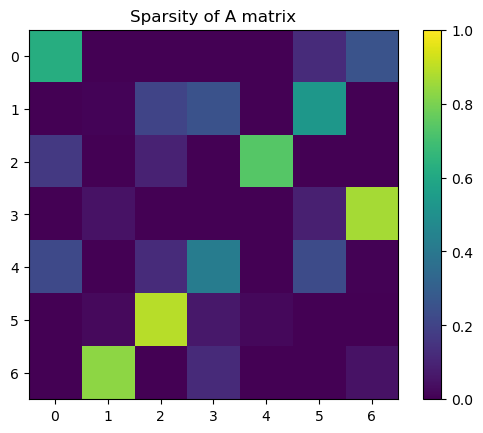

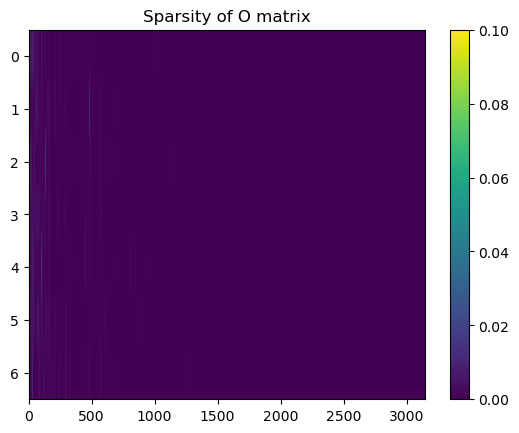

In [10]:
visualize_sparsities(HMM10, O_max_cols=len(HMM10.O[0])-1)

In [11]:
def state_top_words(hmm, obs_map_r, n_words=10):
    for state, O_row in enumerate(hmm.O):
        O_row = np.array(O_row)
        top_words = np.argsort(O_row)[-n_words:]
        s = []
        for w in top_words:
            s.append(obs_map_r[w])
        print(f"State: {state}")
        print(", ".join(s).capitalize())

In [12]:
state_top_words(HMM10, snShakespeare.obs_map_r)

State: 0
All, me, by, as, a, with, the, and, of, to
State: 1
Can, shall, doth, from, art, not, it, in, and, i
State: 2
Your, thee, sweet, that, me, a, not, thy, the, my
State: 3
Where, is, this, in, for, if, when, thy, that, and
State: 4
Or, so, heart, self, for, with, love, but, to, of
State: 5
That, thee, his, all, be, is, and, the, in, thy
State: 6
More, be, his, you, do, when, that, which, i, thou
